In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Laboratorio 6 – Análisis de Redes Sociales (ARS)
- Diego Valenuzela - 22309
- Gerson Ramirez - 22281

## Ejercicio 1 y 2 – Descarga y carga de los archivos de datos

Los archivos `traficogt.txt` y `tioberny.txt` ya están disponibles en la carpeta `/data`.  
Cada archivo contiene **tweets en formato JSON**, uno por línea.  
En esta sección cargaremos ambos archivos en DataFrames de `pandas`.


In [9]:
import json
import pandas as pd

def load_jsonl(file_path):
    encodings_to_try = ["utf-8", "utf-8-sig", "utf-16", "latin1"]
    for enc in encodings_to_try:
        try:
            records = []
            with open(file_path, encoding=enc) as f:
                for line in f:
                    try:
                        records.append(json.loads(line))
                    except json.JSONDecodeError:
                        continue
            print(f"[OK] Leído {file_path} con encoding='{enc}' → {len(records)} registros")
            return pd.DataFrame(records)
        except UnicodeDecodeError:
            continue
    raise ValueError(f"No pude decodificar {file_path} con {encodings_to_try}")

dfs = {name.split(".")[0]: load_jsonl(data_path / name) for name in files}

traficogt_df = dfs["traficogt"]
tioberny_df = dfs["tioberny"]

traficogt_df.head(2)


[OK] Leído data\traficogt.txt con encoding='utf-16' → 5604 registros
[OK] Leído data\tioberny.txt con encoding='utf-16' → 5019 registros


,id,id_str,url,date,user,lang,rawContent,replyCount,retweetCount,likeCount,...,coordinates,inReplyToTweetId,inReplyToTweetIdStr,inReplyToUser,source,sourceUrl,sourceLabel,media,card,_type
0,1834236045598056867,1834236045598056867,https://x.com/traficogt/status/183423604559805...,2024-09-12 14:22:06+00:00,"{'id': 93938886, 'id_str': '93938886', 'url': ...",es,Es comprensible la resolución... El ruso sabe ...,0,0,1,...,None,NaN,None,None,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",None,snscrape.modules.twitter.Tweet
1,1834029142565658846,1834029142565658846,https://x.com/monymmorales/status/183402914256...,2024-09-12 00:39:56+00:00,"{'id': 976875408, 'id_str': '976875408', 'url'...",es,La corrupción de la @CC_Guatemala\nes descarad...,0,56,84,...,None,NaN,None,None,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,"{'photos': [], 'videos': [], 'animated': []}",{'title': 'La Corte de Constitucionalidad orde...,snscrape.modules.twitter.Tweet


## 3. Limpieza y preprocesamiento

Las principales tareas de limpieza aplicadas son:

- Normalización a minúsculas.
- Eliminación de URLs, menciones (@usuario), hashtags, números y signos de puntuación.
- Eliminación de stopwords en español.
- Opcional: eliminación de emoticones (para este análisis no aportan a relaciones de usuarios).
- Extracción de metadatos clave: ID de usuario, texto limpio, menciones, respuestas, retweets.
- Eliminación de duplicados.
- Normalización de nombres de usuario para evitar inconsistencias.


In [10]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stopwords_es = set(stopwords.words("spanish"))

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"http\S+", " ", text)           # URLs
    text = re.sub(r"@\w+", " ", text)              # menciones
    text = re.sub(r"#\w+", " ", text)              # hashtags
    text = re.sub(r"[0-9]+", " ", text)            # números
    text = re.sub(r"[^\w\s]", " ", text)           # signos puntuación
    tokens = text.split()
    tokens = [t for t in tokens if t not in stopwords_es]
    return " ".join(tokens)

for name, df in dfs.items():
    df["text_clean"] = df["rawContent"].apply(clean_text)
    df.drop_duplicates(subset=["id"], inplace=True)

traficogt_df[["rawContent", "text_clean"]].head(3)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,rawContent,text_clean
0,Es comprensible la resolución... El ruso sabe ...,comprensible resolución ruso sabe engrasar maq...
1,La corrupción de la @CC_Guatemala\nes descarad...,corrupción descarada falsificación documentos ...
2,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,


## 4. Análisis Exploratorio

Exploramos:
- Cantidad de tweets y usuarios únicos.
- Número de menciones, respuestas y retweets.
- Hashtags más frecuentes.
- Visualización con nube de palabras.

Esto permite generar preguntas de investigación iniciales.


=== traficogt ===
Tweets: 5596
Usuarios únicos: 2071
Menciones totales: 10910
=== tioberny ===
Tweets: 4944
Usuarios únicos: 2620
Menciones totales: 17242


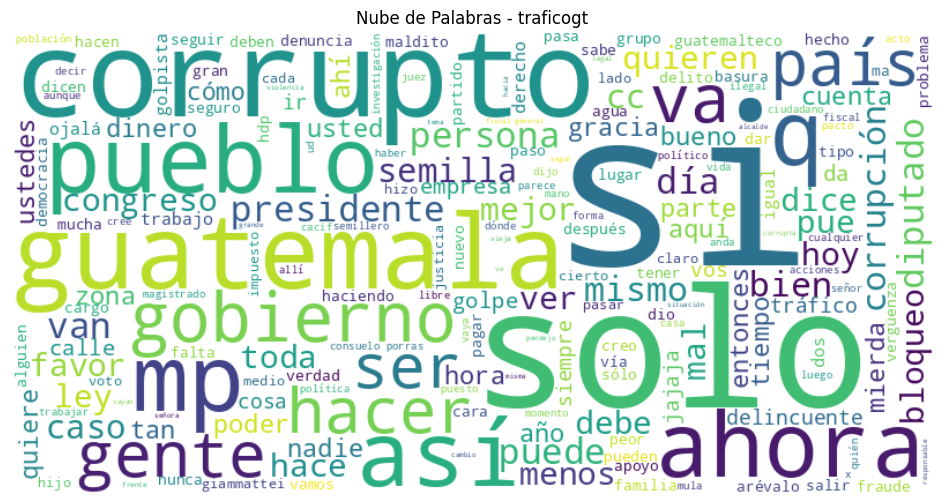

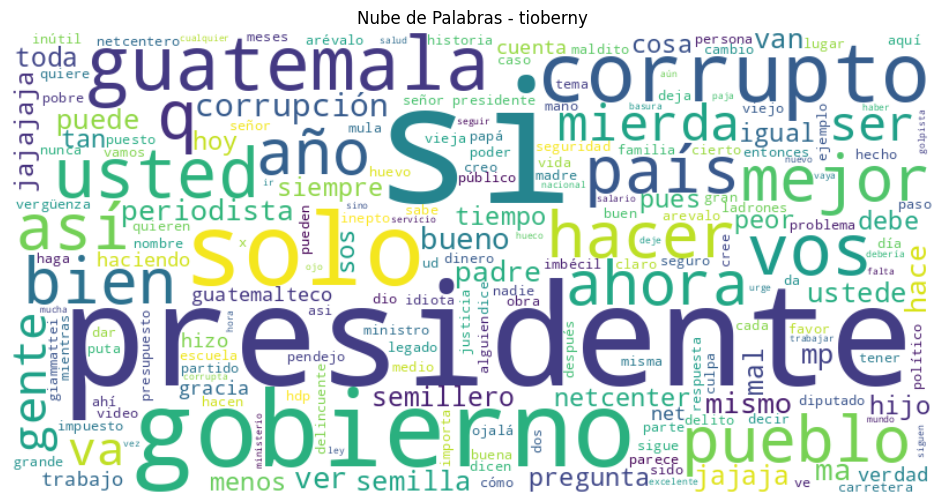

In [ ]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def exploratory_stats(df, name):
    print(f"=== {name} ===")
    print("Tweets:", len(df))
    print("Usuarios únicos:", df["user"].apply(lambda x: x["username"]).nunique())

    mentions = sum(df["mentionedUsers"].dropna().apply(lambda x: len(x)))
    print("Menciones totales:", mentions)

exploratory_stats(traficogt_df, "traficogt")
exploratory_stats(tioberny_df, "tioberny")

wc = WordCloud(width=800, height=400, background_color="white").generate(" ".join(traficogt_df["text_clean"]))
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de Palabras - traficogt")
plt.show()

wc2 = WordCloud(width=800, height=400, background_color="white").generate(" ".join(tioberny_df["text_clean"]))
plt.figure(figsize=(12,6))
plt.imshow(wc2, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de Palabras - tioberny")
plt.show()


### Preguntas planteadas
1. ¿Qué usuarios son los más mencionados en cada dataset?
2. ¿Existen diferencias en la densidad de interacciones entre `traficogt` y `tioberny`?
3. ¿Qué temas emergen (hashtags más frecuentes) y cómo se relacionan con los usuarios más activos?

Estas preguntas guiarán el análisis de red en el siguiente paso.
